# Generate data with distribution control

In [12]:
import polars as pl
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# generate data to test the performance of groupby queries under different distributions of the same number of group keys
# generate n_rows tuples with n_groups group keys, the set of group keys range from 0 to n_groups-1
# generate tuples of (value, group0, group1, group2, ...) where the i-th group key is distributed as group_distributions[i]. each group should have at least one row

n_rows = 10 ** 8
n_groups = 10 ** 6
group_distributions = ["uniform", "normal", "exponential"]
records = []

# make sure each group has at least one row
for i in range(n_groups):
    row = {}
    row['value'] = np.random.randint(0, 1000)
    for dist in group_distributions:
        row[dist] = i
    records.append(row)
    
# all other rows get random group key according to some distribution
for i in range(n_rows - n_groups):
    row = {}
    row['value'] = np.random.randint(0, 1000)
    for dist in group_distributions:
        match dist:
            case "uniform":
                group_key = random.randint(0, n_groups - 1)
            case "normal":
                group_key = -1
                while group_key < 0 or group_key >= n_groups:
                    group_key = int(np.random.normal(n_groups / 2, n_groups / 8))
            case "exponential":
                group_key = -1
                while group_key < 0 or group_key >= n_groups:
                    group_key = int(np.random.exponential(n_groups / 5))
        row[dist] = group_key
    records.append(row)

In [ ]:
df = pl.DataFrame(records)
df.write_parquet(f"gen_v1_{n_rows}_{n_groups}.parquet")

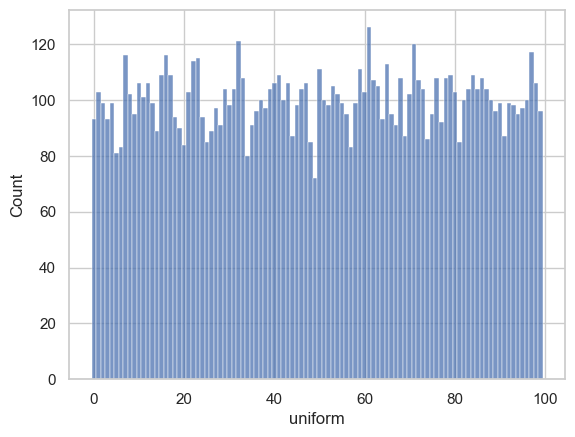

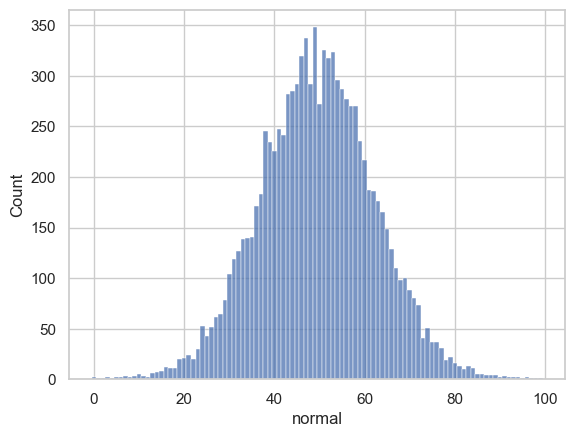

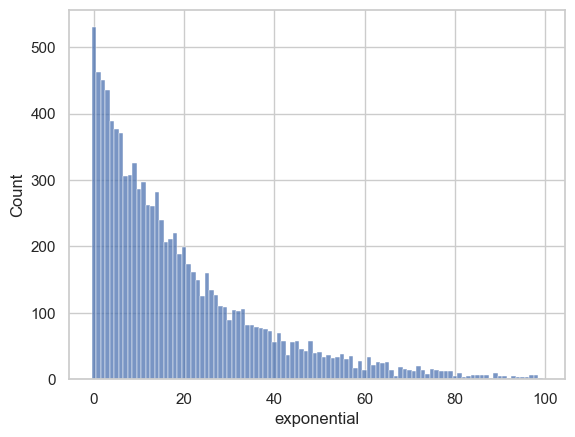

In [ ]:
sns.histplot(data=df, x="uniform", discrete=True)
plt.show()
sns.histplot(data=df, x="normal", discrete=True)
plt.show()
sns.histplot(data=df, x="exponential", discrete=True)
plt.show()

In [4]:
# compute ground truth
for dist in group_distributions:
    res = df.sql(f"select {dist}, sum(value) as sum_value from self group by {dist} order by {dist}")
    display(res)

uniform,sum_value
i64,i64
0,48700
1,50874
2,50939
3,45818
4,52255
…,…
95,49650
96,53576
97,47657


normal,sum_value
i64,i64
0,494
1,57
2,95
3,662
4,545
…,…
95,1063
96,106
97,468


exponential,sum_value
i64,i64
0,270185
1,248895
2,227742
3,202329
4,221627
…,…
95,2775
96,967
97,2814
